# Deep Learning Project: corrosion detection on steel pipes

_Teacher: Emmanuelle Claeys_

_Student: Thomas Labreur (student ID: 21512408)_

_M2 SID University Toulouse III Paul Sabatier_

This notebook contains the main part of the deep learning project I performed in 2024. The aim is studying images representing pipes thickness and to identify areas with corrosion. For that, a convolutionnal neural network (CNN) will be trained on those images which have been cut into patches of 36x36 pixels.

You can find the total project with data files, model's weight files and some library I developped for pre-processing, augmentation and evaluation on my github page: https://github.com/Thomas-labreur/CorroSeg.git


In [1]:
# Generic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import random

# Deep learning modules
from keras import Model
from keras.layers import Conv2D, Dense, Input, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# My own modules 
from iou import IoU
from data_utils import preprocess, data_augmentation

## Retreive data

Here one can find out how our data look like and below the groundtruth, in other words, the corrosion areas we want to detect. As one can see, some data have outlier pixels with high negative values, and other have missing values.

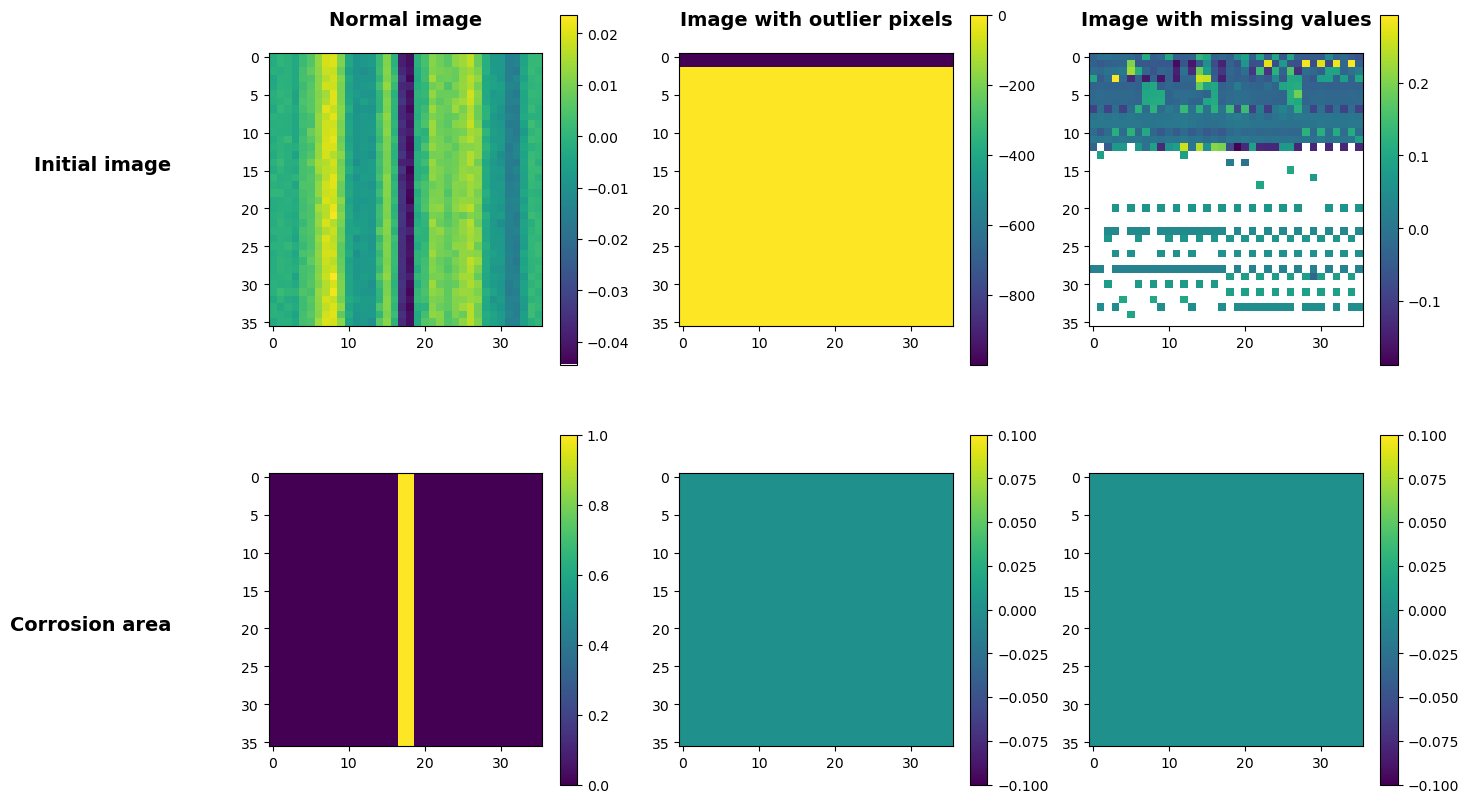

In [2]:
# Groundtruth
y_train = pd.read_csv("data/y_train.csv", index_col=0)

# Pick up some examples
outlier_example = "well_10_patch_0"
nan_example = "well_15_patch_202"
normal_example = "well_1_patch_0"

# Figure initialization
titles = ["Normal image", "Image with outlier pixels", "Image with missing values"]
fig, ax = plt.subplots(2,3, figsize=(15,10))
fig.text(0.06, 0.73 , 'Initial image', va='center', ha='right', fontsize=14, fontweight='bold')
fig.text(0.06, 0.27 , 'Corrosion area', va='center', ha='right', fontsize=14, fontweight='bold')


for i, name in enumerate([normal_example, outlier_example, nan_example]):
    
    # Load image and groundtruth
    x = np.load("data/x_train/" + name + ".npy")
    y = y_train.loc[name].values.reshape((36,36))
    
    # Plot image and groundtruth below
    ax[0,i].set_title(titles[i], fontsize=14, fontweight='bold', pad=20)
    im1 = ax[0,i].imshow(x)
    im2 = ax[1,i].imshow(y)
    plt.colorbar(im1, ax = ax[0,i])
    plt.colorbar(im2, ax = ax[1,i])
    


## Data pre-processing

As recommended on the context document, the pre-processing step is divided in three steps:

- The images with missing values will be removed (there's only two of them)
- The images containing outlier pixels will be removed. Outlier pixels are aberrant values which I considered as values with a z-score greater than 3 (a pixel z_score is computed with respect to the overall collection of images, not only the one to which the pixel belongs).
- The remaining images will be scaled using a robust scaler.

In [3]:
# Pre-process X
# The following function handles all the pre-processing and returns names of inlier patches and themselves after scaling.
inlier_names, X = preprocess("data/x_train", 3) # 3 is the limit z_score for outlier detection

# Only keep y values for inlier patches
y = y_train.loc[inlier_names]

340 files have been removed, 9334 still remain.


Here some examples of clean data.

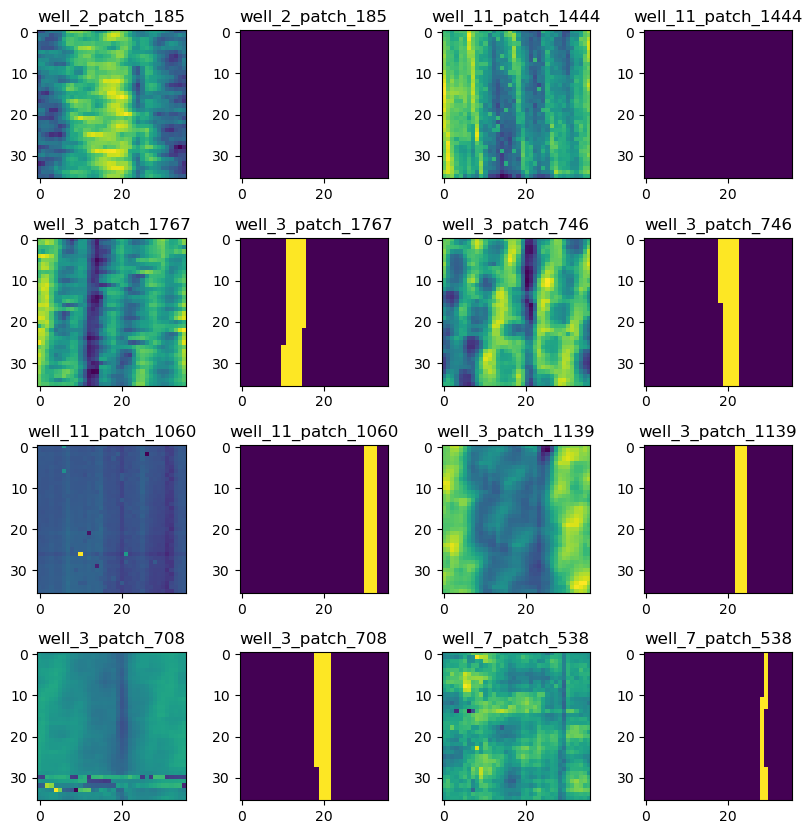

In [4]:
# Random examples
examples = random.sample(range(len(X)), 8)

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=.4)
for i, ex in enumerate(examples):
    plt.subplot(4,4, 2*i+1)
    plt.imshow(X[ex])
    plt.title(inlier_names[ex])
    plt.subplot(4,4,2*i+2)
    plt.imshow(y.loc[inlier_names[ex]].values.reshape(36,36))
    plt.title(inlier_names[ex])


## Data aumentation

As suggested in the context document, we'll use some data augmentation techniques to generates a larger dataset $X$. Two methods will be used here:
- flipping each images horizontally and vertically (adds $2n$ images where $n$ is the number of original images).
- rolling each image horizontally with all possible shift values between 1 and 35 (adds $35n$ values).

This will multiply by $38$ our dataset. Of course, the same operation must be applied to the output data $y$. 

BEFORE augmentation
Input data shape: (9334, 36, 36, 1)
Output data shape:  (9334, 1296)

AFTER augmentation
Input data shape: (354692, 36, 36, 1)
Output data shape:  (354692, 1296)


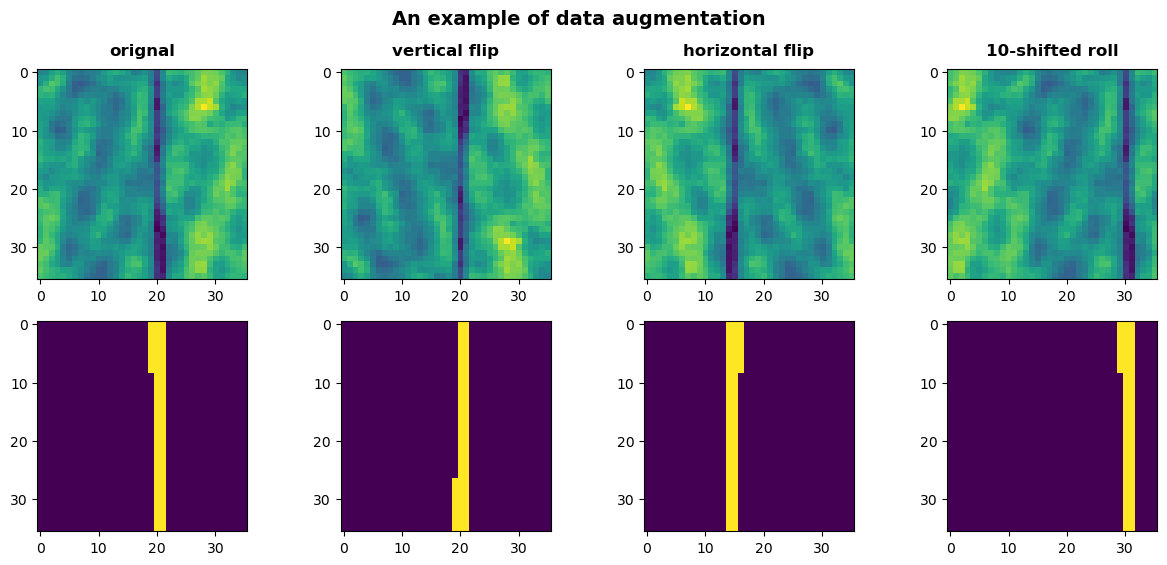

55595

In [5]:
# This fuction handle data augmentation as described above
X_augmented, y_augmented = data_augmentation(X,y)

# Display shapes
print("BEFORE augmentation")
print("Input data shape:", X.shape)
print("Output data shape: ", y.shape)
print("\nAFTER augmentation")
print("Input data shape:", X_augmented.shape)
print("Output data shape: ", y_augmented.shape)

# Visualization of data augmentation
name = "well_1_patch_16"
titles = ['orignal', 'vertical flip','horizontal flip', '10-shifted roll']
plt.figure(figsize=(15,6))
plt.suptitle("An example of data augmentation", fontsize=14, fontweight='bold')
for i, text in enumerate(['', "_vflip" , "_hflip", "_10roll"]):
    idx = y_augmented.index.get_loc(name+text)
    plt.subplot(2,4,i+1)
    plt.imshow(X_augmented[idx])
    plt.title(titles[i], fontweight='bold', pad=10)
    plt.subplot(2,4,i+5)
    plt.imshow(y_augmented.iloc[idx].values.reshape(36,36)) 
plt.show()


# del useless data to free RAM
del y_train, outlier_example, normal_example, nan_example, titles, fig, ax, i, name, inlier_names, X, y, x, examples, ex, idx, text
gc.collect()


In [ ]:
# Save augmented data
#np.save("data/X_augmented.npy", X_augmented)
#y_augmented.to_csv("data/y_augmented.csv")

## Model

In this part, we'll build and train the model. We're going to follow the benchmark guidelines. First let's split our data between train and validation data.

In [ ]:
# read augmented data
#X_augmented, y_augmented = np.load("data/X_augmented.npy"), pd.read_csv("data/y_augmented.csv")
print("data loaded")

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_augmented, y_augmented, test_size=0.1, random_state=5)
print("data splited")

# Free memory
del X_augmented, y_augmented
gc.collect()

data loaded


Now, we'll define a model. As suggested in the benchmark, a CNN with 5 convolutional layers will be used. I also choose to add two dense layers. The following hyperparameters will be used:
- relu activation for hidden layers;
- sigmoid activation for the output layer;
- binary crossentropy as loss;
- adam with learning rate 0.001 as optimizer;
- 10 epohs (it takes almost 3 hours for training);
- batches of size 128.

This model is saved in the CNN1.weights.h5 file. CNN0 is the same model but without data augmentation,  and CNN2 is the same with batch normalization, learning rate exponential decay and gradient clipping. I choose to let CNN1 here because it's the one having the best results on X_test. 

In [ ]:
# Model definition
inputs = Input(shape = (36,36,1))

# Here you can add BatchNormalization layers between each of these for CNN2
x = Conv2D(8, (3,3), activation='relu')(inputs)
x = Conv2D(16, (3,3), activation='relu')(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
outputs = Dense(36*36, activation='sigmoid')(x)

# Model creation
model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36, 36, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 34, 34, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     8,652,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1296)           │       130,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,882,036 (33.88 MB)

 Trainable params: 8,882,036 (33.88 MB)

 Non-trainable params: 0 (0.00 B)

Now the model is ready to be trained.

Epoch 1/10
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1215s 459ms/step - loss: 0.1254 - val_loss: 0.0675 - learning_rate: 9.9900e-04
Epoch 2/10
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1205s 459ms/step - loss: 0.0610 - val_loss: 0.0546 - learning_rate: 9.9800e-04
Epoch 3/10
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1154s 439ms/step - loss: 0.0454 - val_loss: 0.0457 - learning_rate: 9.9700e-04
Epoch 4/10
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1133s 431ms/step - loss: 0.0343 - val_loss: 0.0422 - learning_rate: 9.9601e-04
Epoch 5/10
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1131s 431ms/step - loss: 0.0269 - val_loss: 0.0389 - learning_rate: 9.9501e-04
Epoch 6/10
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1136s 433ms/step - loss: 0.0226 - val_loss: 0.0385 - learning_rate: 9.9402e-04
Epoch 7/10
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1126s 429ms/step - loss: 0.0196 - val_loss: 0.0402 - learning_rate: 9.9302e-04
Epoch 8/10
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1124s 428ms/step - loss: 0.0177 - val_loss: 0.0395 - learning_rate: 9.9203e-04
Epoch 9/10
2626/2626 ━━━━━━━━━━━

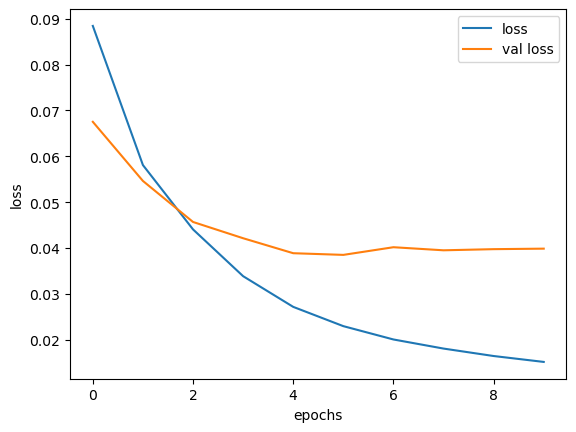

In [ ]:
# Parameters
batch_size = 128
epochs = 10
learning_rate = 0.001
file_weights = "models/CNN1.weights.h5"

# Exponential decay
def exp_decay(epoch, lr):
    return lr * np.exp(-learning_rate)

# Callback to keep only the best weights and add exponential decay
weights_save = ModelCheckpoint(file_weights, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
lr_sched = LearningRateScheduler(exp_decay)

# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate), # you can add clipnorm=1 to adam's argument for gradient clipping
              loss=BinaryCrossentropy)

# Train model
model.fit(X_train, y_train, 
          batch_size = batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          callbacks=[weights_save])  # you can add lr_sched here for exponential lr decay

# Plot loss evolution through epochs
hist = model.history.history
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
# Save weights
# model.save_weights('models/CNN1.weights.h5')

## Test model

In this part, we will test the model's performances on the validation data, using the IoU metric (Intersection over Union).

In [ ]:
# Load weights
model.load_weights('models/CNN1.weights.h5')
pred = pd.DataFrame(model.predict(X_val, verbose=1), index = y_val.index, columns=y_val.columns)

As the model associates a value between 0 and 1 to each pixels, and we want only 0 and 1, we have to set up a threshold above witch a pixel is considered as 1 (corrosion). For that, let's try different threshold values and take the one that gives the best IoU on the (X_val, y_val) dataset.

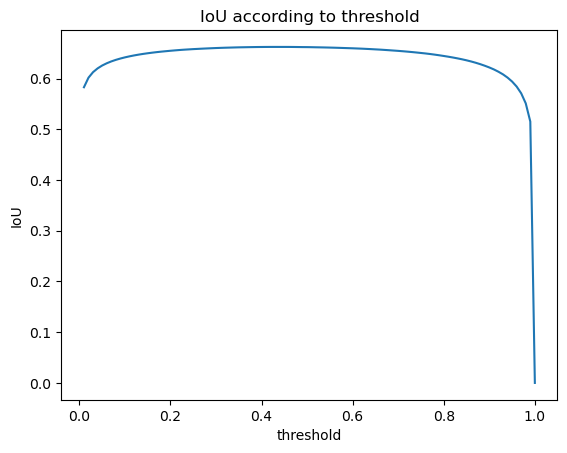

Best threshold:  0.43
Intersection over Union: 0.6625603576242518


In [ ]:
# Initialize iou list and threshold list
iou = []
thresholds = 0.01*np.arange(1,101)

# Compute IoU for each threshold
for th in thresholds:  
    pred_th = 1*(pred > th)
    iou.append(IoU(pred_th, y_val))

# Plot results
plt.title("IoU according to threshold")
plt.plot(thresholds, iou)
plt.xlabel("threshold")
plt.ylabel("IoU")
plt.show()

# Keep the best threshold
best_th = thresholds[np.argmax(iou)]
best_iou = np.max(iou)
best_pred = 1*(pred > best_th)
print("Best threshold: ", best_th)
print("Intersection over Union:", best_iou)

Finally, we can compare the model output with reality for more visual results.

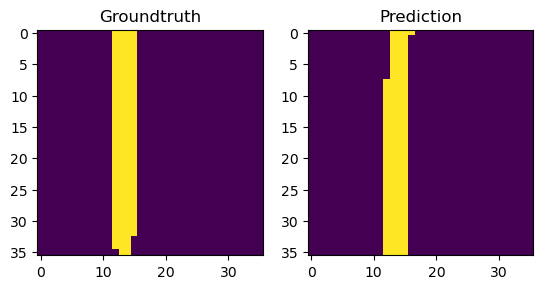

In [28]:
# Choose an indice
i= 945

# Plot groundtruth
plt.subplot(1,2,1)
plt.title("Groundtruth")
plt.imshow(y_val.iloc[i].values.reshape(36,36))

# Plot prediction
plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(best_pred.iloc[i].values.reshape(36,36))

plt.show()

## Use model on the x_test dataset

The project also provides a dataset named "x_test" with new data without the corresponding y_test. We have to find a prediction and submit it on the website. Here we apply the same pre-processing as for X_train, but without removing aberrant data because the website expects all the test data to be predicted. A way to do so is to set the z_score threshold above which a data is considered as aberrant to a very high value like 200.

In [ ]:
# Preprocessing
inlier_names, X = preprocess("data/x_test", 200)
print("Size of test dataset:", X.shape)

0 files have been removed, 2538 still remain.
Size of test dataset: (2538, 36, 36, 1)


Now we can predict the corrosion areas.

In [ ]:
# Predict and save into a csv to submit it to the website.
pred = pd.DataFrame((model.predict(X) > best_th) *1, index =inlier_names)
pred.to_csv("data/submission.csv")

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


Here some example to visualize the results.

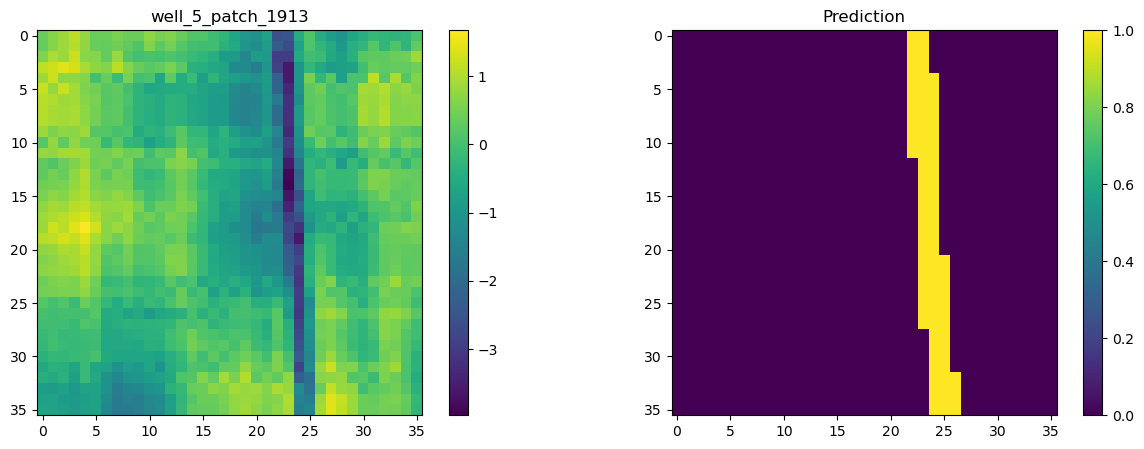

In [34]:
# Random indice
i= np.random.randint(X.shape[0])
plt.figure(figsize=(15,5))

# Original image
plt.subplot(1,2,1)
plt.imshow(X[i])
plt.title(pred.index[i])
plt.colorbar()

# Prediction
plt.subplot(1,2,2)
plt.imshow(pred.iloc[i].values.reshape(36,36))
plt.title("Prediction")
plt.colorbar()

plt.subplots_adjust(hspace=.6)